In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pylab
from matplotlib import pyplot as plt
from collections import namedtuple

Environment

In [0]:
class actSpace(object):
    def __init__(self, actions):
        self.actions = actions
        self.n = len(actions)
        
class gridEnv():
    def __init__(self, max_step):
        super(gridEnv, self).__init__()

        # 16 states
        self.S = range(16)
        # 4 actions
        """actions: 0 - up, 1 - right, 2 - Left, 3 - down"""
        self.action_space = actSpace(range(4))

        self.pos()

        # Set all states with 0 reward except for the last state(with reward 100)
        self.R = [0] * len(self.S)
        self.R[15] = 100
                
        # Number of steps per episode.
        self.max_step = max_step
        
    # States with their possible transitions
    def pos(self):
        self.pos = {}
        self.pos[0] = [1, 4]
        self.pos[1] = [0, 2, 5]
        self.pos[2] = [1, 3, 6]
        self.pos[3] = [2, 7]
        self.pos[4] = [0, 5, 8]
        self.pos[5] = [1, 4]
        self.pos[6] = [2, 7]
        self.pos[7] = [3, 6, 11]
        self.pos[8] = [4, 9, 12]
        self.pos[9] = [8, 13]
        self.pos[10] = [11, 14]
        self.pos[11] = [7, 10, 15]
        self.pos[12] = [8, 13]
        self.pos[13] = [9, 12, 14]
        self.pos[14] = [10, 13, 15]
        self.pos[15] = [11, 14]
        return self.pos
      
    def step(self, action):
        s_prev = self.s
        self.s = self.change_state(self.s, action)
        reward = self.assign_reward(self.s, s_prev, self.R)
        self.nstep += 1
        self.is_reset = False

        # Reset episode when goal or max step is reached 
        if reward > 0 or self.nstep == self.max_step:
            self.reset()

        return (self.reset_grid_state(self.s), reward, self.is_reset, '')
    
    # up -4, right +1, left -1, down +4
    def change_state(self, s, a):
        if a < 0 or a > 3:
            raise ValueError('action invalid', a)
        if a == 0 and (s-4 in self.pos[s]):
            s -= 4
        elif a == 1 and (s+1 in self.pos[s]):
            s += 1
        elif a == 2 and (s-1 in self.pos[s]):
            s -= 1
        elif a == 3 and (s+4 in self.pos[s]):
            s += 4
        return s

    def assign_reward(self, s, s_prev, rewards):
        if s == s_prev:
            return 0
        return rewards[s]
       
    def reset(self):
        self.nstep = 0
        self.s = 0
        self.is_reset = True
        return self.reset_grid_state(self.s)
    
    def reset_grid_state(self, s):
        reset_grid = np.zeros(len(self.S), dtype=np.float32)
        # Mark start state with index 0 as 1
        reset_grid[s] = 1
        return reset_grid

Simulation

In [0]:
class Experiment(object):
    def __init__(self, env, agent):
        
        self.env = env
        self.agent = agent
        
        self.episode_length = np.array([0])
        self.episode_reward = np.array([0])
        
        self.fig = pylab.figure(figsize=(10, 5))
          
    def run_qlearning(self, max_number_of_episodes, display_frequency=1):

        # repeat for each episode
        for episode_number in range(max_number_of_episodes):
            
            # initialize state
            state = self.env.reset()
            
            done = False # used to indicate terminal state
            R = 0 # used to display accumulated rewards for an episode
            t = 0 # used to display accumulated steps for an episode i.e episode length
            
            # repeat for each step of episode, until state is terminal
            while not done:
                
                t += 1 # increase step counter - for display
                
                # choose action from state using policy derived from Q
                action = self.agent.act(state)
                
                # take action, observe reward and next state
                next_state, reward, done, _ = self.env.step(action)
                
                # agent learn (Q-Learning update)
                self.agent.learn(state, action, reward, next_state, done)
                
                # state <- next state
                state = next_state
                
                R += reward # accumulate reward - for display
            
            self.episode_length = np.append(self.episode_length,t) # keep episode length - for display
            self.episode_reward = np.append(self.episode_reward,R) # keep episode reward - for display 

        plot_charts(self.fig, self.episode_length, self.episode_reward, display_frequency)

Plotting

In [0]:
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_episode_stats(stats, smoothing_window=10, hideplot=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Time step")
    plt.title("Episode Length over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Reward per episode")
    plt.title("Episode Reward over Time".format(smoothing_window))
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return fig1, fig2
  
def plot_charts(fig, episode_length, episode_reward, display_frequency):
    fig.clf()
    stats = EpisodeStats(episode_lengths=episode_length, episode_rewards=episode_reward)                             
    plot_episode_stats(stats, display_frequency)

ReplayMemory

In [0]:
class tf_ReplayMemory(object):
    """Implements basic replay memory"""

    def __init__(self, observation_size, max_size):
        self.observation_size = observation_size
        self.num_observed = 0
        self.max_size = max_size
        self.samples = {
                 'obs'      : np.zeros(self.max_size * 1 * self.observation_size,
                                       dtype=np.float32).reshape(self.max_size, 1, self.observation_size),
                 'action'   : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
                 'reward'   : np.zeros(self.max_size * 1).reshape(self.max_size, 1),
                 'terminal' : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
               }

    def store(self, state, action, reward, done):
        index = self.num_observed % self.max_size
        self.samples['obs'][index, :] = state
        self.samples['action'][index, :] = action
        self.samples['reward'][index, :] = reward
        self.samples['terminal'][index, :] = done

        self.num_observed += 1

    def sample_minibatch(self, minibatch_size):
        max_index = min(self.num_observed, self.max_size) - 1
        sampled_indices = np.random.randint(max_index, size=minibatch_size)
       
        s      = (np.asarray(self.samples['obs'][sampled_indices, :], dtype=np.float32))
        s_next = (np.asarray(self.samples['obs'][sampled_indices+1, :], dtype=np.float32))
        a      = (self.samples['action'][sampled_indices].reshape(minibatch_size))
        r      = self.samples['reward'][sampled_indices].reshape((minibatch_size, 1))
        done   = self.samples['terminal'][sampled_indices].reshape((minibatch_size, 1))

        return (s, a, r, s_next, done)

Agent

In [0]:
class Agent(object):  
        
    def __init__(self, actions):
        self.actions = actions
        self.num_actions = len(actions)

    def act(self, state):
        raise NotImplementedError

DQN agent

In [0]:
class tf_DQLearningAgent(Agent):
    """Q-Learning agent with function approximation."""

    #def __init__(self, actions, obs_size, **kwargs):
    def __init__(self, actions, obs_size, nhidden,
                 epoch_length, 
                 epsilon, gamma, learning_rate, tau, replace_target_iter,
                 mem_size, minibatch_size, **kwargs):
        super(tf_DQLearningAgent, self).__init__(actions)

        self.obs_size = obs_size
        self.nhidden = nhidden
        
        self.epoch_length = epoch_length

        self.epsilon = epsilon
        self.gamma = gamma
        self.learning_rate = learning_rate
        
        self.tau = tau
        self.replace_target_iter = replace_target_iter
        
        self.memory = tf_ReplayMemory(self.obs_size, mem_size)
        self.minibatch_size = minibatch_size

        self.step_counter = 0
        self.learn_step_counter = 0
        self.current_loss = .0      
        
        tf.reset_default_graph()
        self.built_graph()
        
        self.target_net_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
        self.model_net_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model_net')

        with tf.variable_scope('hard_replacement'):
            #self.target_replace_op = [tf.assign(t, m) for t, m in zip(self.target_net_params, self.model_net_params)]
            self.target_replace_op = [t.assign(m) for t, m in zip(self.target_net_params, self.model_net_params)]
        with tf.variable_scope('soft_replacement'):            
            #self.target_replace_op_soft = [tf.assign(t, self.tau * m + (1 - self.tau) * t) for t, m in zip(self.target_net_params, self.model_net_params)]                
            self.target_replace_op_soft = [t.assign(self.tau * m + (1 - self.tau) * t) for t, m in zip(self.target_net_params, self.model_net_params)]                

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        self.sess.run(self.target_replace_op)
        
    def act(self, state):
        
        if np.random.random() < self.epsilon:
            i = np.random.randint(0,len(self.actions))
        else: 
            #Q = self.model_network(Variable(state.reshape(1, state.shape[0])))
            #i = Q.data.argmax()       
            actions_value = self.sess.run(self.model_action_values, feed_dict={self.s: np.reshape(state, (1,state.shape[0]))})
            i = np.argmax(actions_value)
            
        self.step_counter += 1 
        # decay epsilon after each epoch
        if self.step_counter % self.epoch_length == 0:
            self.epsilon = max(.01, self.epsilon * .95)
        
        action = self.actions[i]        
        return action     
    
    def learn(self, state1, action1, reward, state2, done):
        self.memory.store(state1, action1, reward, done)
        # start training after 1 epoch
        if self.step_counter > self.epoch_length:
            self.current_loss = self.update_model()
      
    # Max Q values from target network or policy (greedy)
    def compute_y(self, s, action, reward, s_next, is_terminal, Q_hat):
        # compute Q targets (max_a' Q_hat(s_next, a'))
        #Q_hat_max = F.max(Q_hat, axis=1, keepdims=True)        
        Q_hat_max = tf.reduce_max(Q_hat, axis=1, keepdims=True)
                
        #y = (1-is_terminal) * self.gamma * Q_hat_max + reward
        #y = tf.math.multiply((1.0 - tf.cast(is_terminal, tf.float32)), tf.math.multiply(self.gamma, Q_hat_max)) + reward
        #y = (1.0 - tf.cast(is_terminal, tf.float32)) * tf.math.multiply(self.gamma, Q_hat_max) + reward
        
        # Pair, do not compute gradient for target net (coz don't want to update it's w, b by it's bkprop), 
        # only want to update target net params (ie. w, b) with model net params.
        y = tf.math.multiply(self.gamma, Q_hat_max) + reward
        y = tf.stop_gradient(y)
        
        return y
      
    # Q values of actions selected from model network or behaviour policy (e-greedy)  
    def compute_Q_subset(self, s, action, reward, s_next, is_terminal, Q):
        # compute Q(s, action)
       
        action = tf.cast(action, tf.int32)
        arr = tf.range(tf.shape(action)[0], dtype=tf.int32)
        a_indices = tf.stack([arr, action], axis=1)
        Q_subset = tf.gather_nd(Q, a_indices)
        Q_subset = tf.reshape(Q_subset, (self.minibatch_size, 1))
        
        return Q_subset 
      
    # Huber loss
    def compute_Huber_loss(self, y, Q_subset):
        error = y - Q_subset
        loss_clipped = abs(error) * tf.cast((abs(error) > 1), tf.float32) + (error**2) * tf.cast((abs(error) <= 1), tf.float32)
        loss = np.sum(loss_clipped) / self.minibatch_size

        return loss             
      
    def built_graph(self):              
        #(s, action, reward, s_next, is_terminal)
        #(32, 1, 16) (32,) (32, 1) (32, 1, 16) (32, 1)
        self.s = tf.placeholder(tf.float32, [None,16], name='s')
        self.action = tf.placeholder(tf.int16, [None,], name='a')
        self.reward = tf.placeholder(tf.float32, [None,1], name='r')
        self.s_next = tf.placeholder(tf.float32, [None,16], name='s_next')
        self.is_terminal = tf.placeholder(tf.int16, [None,1], name='is_terminal')           
                
        # use LeCunUniform weight initialization for weights
        initializer = tf.initializers.lecun_uniform()
        bias_initializer = tf.initializers.he_uniform(1e-4)

        # behavioural policy, gives Q(A|S), policy eval. 
        with tf.variable_scope('model_net'):
          model_feature_layer = tf.contrib.layers.fully_connected(self.s, self.nhidden, 
                                                              activation_fn = tf.nn.relu,
                                                              weights_initializer = initializer,
                                                              biases_initializer = bias_initializer)
          self.model_action_values = tf.contrib.layers.fully_connected(model_feature_layer, self.num_actions, 
                                                              activation_fn = None,
                                                              weights_initializer = initializer,
                                                              biases_initializer = bias_initializer) 
          
        # target policy, gives Q(A_next|S_next), max over Q(A_next|S_next) to compute target y, policy improvement.
        with tf.variable_scope('target_net'):
          target_feature_layer = tf.contrib.layers.fully_connected(self.s_next, self.nhidden, 
                                                              activation_fn = tf.nn.relu,
                                                              weights_initializer = initializer,
                                                              biases_initializer = bias_initializer)
          self.target_action_values = tf.contrib.layers.fully_connected(target_feature_layer, self.num_actions, 
                                                              activation_fn = None,
                                                              weights_initializer = initializer,
                                                              biases_initializer = bias_initializer)     
        with tf.variable_scope('y'):
          y = self.compute_y(self.s, self.action, self.reward, self.s_next, self.is_terminal, self.target_action_values)
        with tf.variable_scope('Q_subset'):
          Q_subset = self.compute_Q_subset(self.s, self.action, self.reward, self.s_next, self.is_terminal, self.model_action_values)
        with tf.variable_scope('loss'):
          self.loss = self.compute_Huber_loss(y, Q_subset)
        with tf.variable_scope('optimizer'):
          self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
        
        return 0
      
    def update_model(self):             
        (s, action, reward, s_next, is_terminal) = self.memory.sample_minibatch(self.minibatch_size)

        s = np.asarray(np.reshape(s, (self.minibatch_size, self.obs_size)))
        s_next = np.asarray(np.reshape(s_next, (self.minibatch_size, self.obs_size)))
        
        _, cost = self.sess.run([self.optimizer, self.loss], feed_dict = {self.s: s,
                                                                          self.action: action,
                                                                          self.reward: reward,
                                                                          self.s_next: s_next,
                                                                          self.is_terminal: is_terminal})      
        self.sess.run(self.target_replace_op_soft)  
        #if self.learn_step_counter % self.replace_target_iter == 0:
        #    self.sess.run(self.target_replace_op)  
        #self.learn_step_counter += 1

Hyper parameters

In [0]:
max_number_of_episodes = 100
epoch_length = 100

obs_size=16
nhidden = 512

epsilon = 1    

gamma = .99
learning_rate = .5     

tau = .001
replace_target_iter = 300

mem_size = 10000
minibatch_size = 32

Graph

step,
soft/hard update

<Figure size 720x360 with 0 Axes>

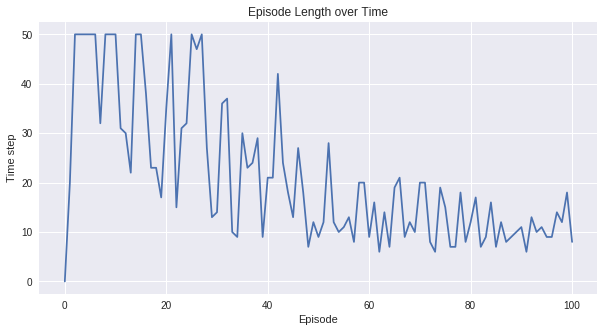

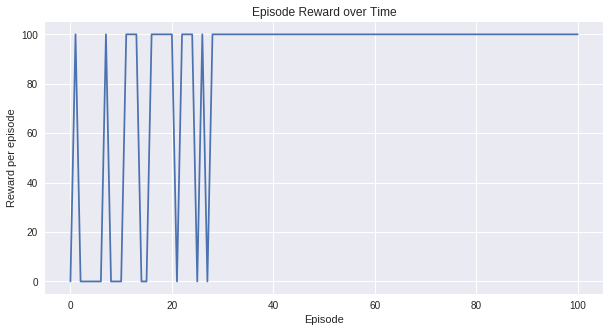

In [0]:
%matplotlib inline
env = gridEnv(50)
agent = tf_DQLearningAgent(range(env.action_space.n), obs_size, nhidden,
                           epoch_length, 
                           epsilon, gamma, learning_rate, tau, replace_target_iter,
                           mem_size, minibatch_size)
experiment = Experiment(env, agent)
experiment.run_qlearning(max_number_of_episodes)